# Requirements

### Download

In [ ]:
!pip install transformers datasets accelerate nvidia-ml-py3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 43.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.5/191.5 KB 11.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 22.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 101.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 17.0 MB/s eta 0:00:00
  Created wheel for nvidia-ml-py3: filename=nvidia_ml_py3-7.352.0-py3-none-any.whl size=19190 sha256=367229f1738aecb7962063735d6cfcca1d8b80bfecdb82ac408918914b6c447f
  Stored in directory: /root/.cache/pip/wheels/b9

### Libraries

In [ ]:
#basics
import pandas as pd
import numpy as np
import gc
from numba import cuda

#Torch
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

#Split data
from sklearn.model_selection import train_test_split

#Bert
from transformers import BertModel, BertTokenizer

In [ ]:
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

<weakproxy at 0x7efcd6df74a0 to Device at 0x7efdc12aac40>

### Else

In [ ]:
graph_labels_path = "/content/drive/MyDrive/graph_labels.txt"
sequences_path = "/content/drive/MyDrive/sequences.txt"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get Data

### Load data

In [ ]:
def read_data_sequence():
  # Read sequences
  sequences = list()
  with open(sequences_path, "r") as f:
      for line in f:
          sequences.append(line[:-1])

  # Split data into training and test sets
  sequences_train = list()
  sequences_test = list()
  proteins_test = list()
  y_train = list()
  with open(graph_labels_path, "r") as f:
      for i, line in enumerate(f):
          t = line.split(",")
          if len(t[1][:-1]) == 0:
              proteins_test.append(t[0])
              sequences_test.append(sequences[i])
          else:
              sequences_train.append(sequences[i])
              y_train.append(int(t[1][:-1]))
  return sequences_train, sequences_test, proteins_test, y_train
sequences_train, sequences_test, proteins_test, y_train = read_data_sequence()

In [ ]:
sequences_train = [" ".join(seq) for seq in sequences_train]
sequences_test = [" ".join(seq) for seq in sequences_test]

In [ ]:
print(len(sequences_train), len(sequences_test), len(proteins_test), len(y_train))

4888 1223 1223 4888


# Data Viz

[]

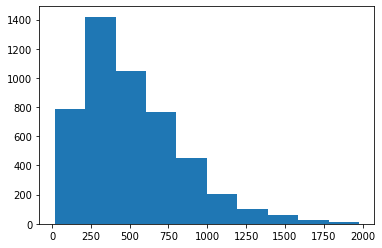

In [ ]:
import matplotlib.pyplot as plt
plt.hist([len(x) for x in sequences_train])
plt.plot()

# TROUBLESHOOTING

https://huggingface.co/docs/transformers/main/en/perf_train_gpu_one

In [ ]:
gc.collect()

torch.cuda.empty_cache()

In [ ]:
from pynvml import *


def print_gpu_utilization():
    nvmlInit()
    handle = nvmlDeviceGetHandleByIndex(0)
    info = nvmlDeviceGetMemoryInfo(handle)
    print(f"GPU memory occupied: {info.used//1024**2} MB.")


def print_summary(result):
    print(f"Time: {result.metrics['train_runtime']:.2f}")
    print(f"Samples/second: {result.metrics['train_samples_per_second']:.2f}")
    print_gpu_utilization()

In [ ]:
print_gpu_utilization()

GPU memory occupied: 3 MB.


In [ ]:
import torch


torch.ones((1, 1)).to("cuda")
print_gpu_utilization()

GPU memory occupied: 780 MB.


Kernel takes less than 1Gb of GPU Memory

In [ ]:
tokenizer_bert = "Rostlab/prot_bert"
tokenizer = BertTokenizer.from_pretrained(tokenizer_bert, do_lower_case=False )
model_bert = "Rostlab/prot_bert"
bert = BertModel.from_pretrained(model_bert).to(device)
print_gpu_utilization()

Downloading:   0%|          | 0.00/81.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/86.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/361 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


GPU memory occupied: 2388 MB.


Model takes 1.6 Gb of GPU memory

# Preprocessing

### Split Data

In [ ]:
test_size = .25
X_train, X_valid, y_train, y_valid = train_test_split(sequences_train, y_train, shuffle= True, test_size = test_size)

### Create Dataset and Dataloader

In [ ]:
#max_len_seq = np.quantile([len(x) for x in sequences_train],.9)
max_len = 512

In [ ]:
X_train = [x[:512] for x in X_train]
X_valid = [x[:512] for x in X_valid]

In [ ]:
tokenizer_bert = "Rostlab/prot_bert"
tokenizer = BertTokenizer.from_pretrained(tokenizer_bert, do_lower_case=False )

In [ ]:
class ProteinSequenceDataset(Dataset):
    def __init__(self, sequence, targets, tokenizer, max_len):
        self.sequence = sequence
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.sequence)

    def __getitem__(self, item):
        sequence_one = str(self.sequence[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            sequence_one,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        ).to(device)
        return {
          'protein_sequence': sequence_one,
          'input_ids': encoding['input_ids'].flatten().to(device),
          'attention_mask': encoding['attention_mask'].flatten().to(device),
          'targets': torch.tensor(target, dtype=torch.long).to(device)
        }


In [ ]:
batch_size = 8

training_dataset = ProteinSequenceDataset(X_train, y_train,tokenizer,max_len)
valid_dataset = ProteinSequenceDataset(X_valid, y_valid,tokenizer, max_len)
training_dataloader = DataLoader(training_dataset, batch_size = batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle=True)

## Build Model

In [ ]:
model_bert = "Rostlab/prot_bert"

### Second Approach: token, class in same model 

In [ ]:
class ProteinClassifier(nn.Module):
    def __init__(self, n_classes, dropout):
        super(ProteinClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(model_bert).to(device)
        self.classifier = nn.Sequential(nn.Dropout(p=dropout),
                                        nn.Linear(self.bert.config.hidden_size, n_classes),
                                        nn.Tanh()).to(device)
        
    def forward(self, input_ids, attention_mask):
        output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        ).pooler_output
        hat_y = self.classifier(output) 
        del output
        return hat_y

# Train 

In [ ]:
#hyper params
n_class = len(set(y_train))
lr =  5e-5
eps = 1e-08
dropout = .2

#model
model = ProteinClassifier(n_class, dropout).to(device)

opt = optim.AdamW(model.parameters(), 
                              lr = lr,
                              eps = eps
                              )

criterion = nn.NLLLoss()

In [ ]:
# Implement a training function, which will train the model with the corresponding optimizer and criterion,
# with the appropriate dataloader, for one epoch.

def train_epoch(model, opt, criterion, dataloader):
    model.train()
    losses = []
    for i, data in enumerate(dataloader):
        input_ids = data['input_ids'].to(device)
        input_mask = data['attention_mask'].to(device)
        labels = data['targets'].to(device)
        opt.zero_grad()
        # (1) Forward
        pred = model.forward(input_ids,attention_mask=input_mask)
        del input_ids, input_mask
        # (2) Compute the loss  
        loss = criterion(pred,labels)
        # (3) Compute gradients with the criterion
        loss.backward()
        # (4) Update weights with the optimizer
        opt.step()    
        losses.append(loss.item())
        # Count the number of correct predictions in the batch - here, you'll need to use the sigmoid
        num_corrects = (torch.argmax(pred, dim=1) == labels).float().sum()
        acc = 100.0 * num_corrects/len(labels)
        
        if (i%20 == 0):
            print("Batch " + str(i) + " : training loss = " + str(loss.item()) + "; training acc = " + str(acc.item()))
    return losses

In [ ]:
# Same for the evaluation ! We don't need the optimizer here. 
def eval_model(model, criterion, evalloader):
    model.eval()
    total_epoch_loss = 0
    total_epoch_acc = 0
    with torch.no_grad():
        for i, data in enumerate(evalloader):
            input_ids = data['input_ids'].to(device)
            input_mask = data['attention_mask'].to(device)
            labels = data['targets'].to(device)
            outputs =  model.forward(input_ids,attention_mask=input_mask)
            del input_ids, input_mask
            _, preds = torch.max(outputs, dim=1)
            loss = criterion(outputs, labels)
            num_corrects =(preds == labels).float().sum()
            acc = 100.0 * num_corrects/len(labels)
            total_epoch_loss += loss.item()
            total_epoch_acc += acc.item()
    return total_epoch_loss/(i+1), total_epoch_acc/(i+1)

# Eval

In [ ]:
# A function which will help you execute experiments rapidly - with a early_stopping option when necessary. 
def experiment(model, opt, criterion, num_epochs = 5, early_stopping = False):
    train_losses = []
    if early_stopping: 
        best_valid_loss = 10. 
    print("Beginning training...")
    for e in range(num_epochs):
        print("Epoch " + str(e+1) + ":")
        train_losses += train_epoch(model, opt, criterion, training_dataloader)
        valid_loss, valid_acc = eval_model(model, criterion, valid_dataloader)
        print("Epoch " + str(e+1) + " : Validation loss = " + str(valid_loss) + "; Validation acc = " + str(valid_acc))
        if early_stopping:
            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
            else:
                print("Early stopping.")
                break  
    return train_losses

In [ ]:
train_losses = experiment(model, opt, criterion,num_epochs=1000)

Beginning training...
Epoch 1:
Batch 0 : training loss = 0.03225409984588623; training acc = 0.0


OutOfMemoryError: ignored

In [ ]:
gc.collect()

35

In [ ]:
torch.cuda.memory_stats()

OrderedDict([('active.all.allocated', 491),
             ('active.all.current', 491),
             ('active.all.freed', 0),
             ('active.all.peak', 491),
             ('active.large_pool.allocated', 182),
             ('active.large_pool.current', 182),
             ('active.large_pool.freed', 0),
             ('active.large_pool.peak', 182),
             ('active.small_pool.allocated', 309),
             ('active.small_pool.current', 309),
             ('active.small_pool.freed', 0),
             ('active.small_pool.peak', 309),
             ('active_bytes.all.allocated', 1680438784),
             ('active_bytes.all.current', 1680438784),
             ('active_bytes.all.freed', 0),
             ('active_bytes.all.peak', 1680438784),
             ('active_bytes.large_pool.allocated', 1677983744),
             ('active_bytes.large_pool.current', 1677983744),
             ('active_bytes.large_pool.freed', 0),
             ('active_bytes.large_pool.peak', 1677983744),
           

In [ ]:
torch.cuda.memory_reserved()

1688207360

In [ ]:
torch.cuda.memory_reserved()

1688207360

In [ ]:
torch.cuda.empty_cache()

In [ ]:
torch.cuda.memory_allocated()

1680438784

# Annexes

In [ ]:
seq_ex = ['A D E']
tar = 2
model_bert = "Rostlab/prot_bert_bfd_localization"
tokenizer_bert = "Rostlab/prot_bert"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = BertTokenizer.from_pretrained(tokenizer_bert, do_lower_case=False )
encoding =  tokenizer.encode_plus(
            seq_ex,
            truncation=True,
            add_special_tokens=True,
            max_length=256,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        ).to(device)
seq_data = {'protein_sequence': seq_ex,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(tar, dtype=torch.long)}
m_test =  BertModel.from_pretrained(model_bert).to(device)
seq_emb = m_test(**encoding)
seq_emb

Downloading:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.68G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_bert_bfd_localization were not used when initializing BertModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[ 0.1042,  0.2596,  0.0237,  ..., -0.2296,  0.1448,  0.1180],
         [ 0.1046,  0.2598,  0.0240,  ..., -0.2297,  0.1448,  0.1178],
         [ 0.1043,  0.2596,  0.0237,  ..., -0.2296,  0.1448,  0.1179],
         ...,
         [ 0.1043,  0.2596,  0.0237,  ..., -0.2296,  0.1448,  0.1179],
         [ 0.1042,  0.2596,  0.0237,  ..., -0.2296,  0.1448,  0.1180],
         [ 0.1042,  0.2596,  0.0237,  ..., -0.2296,  0.1448,  0.1180]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.5750,  0.3330,  0.3089,  ..., -0.2900, -0.3264,  0.3071]],
       device='cuda:0', grad_fn=<TanhBackward0>), hidden_states=None, past_key_values=None, attentions=None, cross_attentions=None)

In [ ]:
#nn.Tanh()(seq_emb.pooler_output).shape
a, b = torch.max(seq_emb.pooler_output, dim=1)
a,b

(tensor([0.6827], device='cuda:0', grad_fn=<MaxBackward0>),
 tensor([721], device='cuda:0'))

In [ ]:
torch.cuda.empty_cache()

In [ ]:
from numba import cuda
cuda.select_device(0)
cuda.close()
cuda.select_device(0)

In [ ]:
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:128

In [ ]:
train_df =  pd.DataFrame({"seq":sequences_train,"length":[len(x) for x in sequences_train]})
train_df.head()

In [ ]:
test_df = pd.DataFrame({"seq":sequences_test, "length":[len(seq) for seq in sequences_test]})
test_df.head()

In [ ]:
prot_seq_input = train_df[['seq']].drop_duplicates()
train_embeddings_list = []
for i, protein in enumerate(prot_seq_input.seq):
    encoded_input = tokenizer(protein, add_special_tokens=True, padding=True, is_split_into_words=True, return_tensors="pt").to(device)
    output = model(**encoded_input)
    output = output[1].detach().cpu().numpy()[0]
    train_embeddings_list.append(output)
    if (i%100 == 0): print(i)

In [ ]:
duplicate = train_df[train_df.duplicated(keep="first")].index.values
for d in duplicate:
  del y_train[d]

In [ ]:
X_train = pd.DataFrame({"ProtBertEmb":train_embeddings_list,"y_train":y_train})
X_train.head()

In [ ]:
## Convert test_df protein sequence  into embeddings
test_prot_seq_input = test_df[['seq']].drop_duplicates()
test_embeddings_list = []
for i in (range(0, len(test_prot_seq_input))):
    sequence_Example = ' '.join([*test_prot_seq_input['seq'].iloc[i]])
    encoded_input = tokenizer(sequence_Example, add_special_tokens=True, padding=True, is_split_into_words=True, return_tensors="pt").to(device)
    output = model(**encoded_input)
    output = output[1].detach().cpu().numpy()[0]
    test_embeddings_list.append(output)
    if (i%100 == 0): print(i)